<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Pollardstown__rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
# Load RGB image
rgb = rasterio.open("/content/pollardstown_ortho.tif")

#load NDVI image
NDVI = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")

# Load habitat map (vector)
habitat = gpd.read_file("/content/Pollardstown_clappied.shp")

In [11]:
print(rgb.crs)
print(NDVI.crs)
print(habitat.crs)

EPSG:2157
EPSG:2157
EPSG:2157


In [6]:
rgb_data = rgb.read()      # (Bands, Height, Width)
ndvi_data = NDVI.read(1)   # (Height, Width)

In [9]:
print(rgb_data.shape[1:]) # Height, Width of RGB
print(ndvi_data.shape)

(40000, 40000)
(12017, 17289)


In [10]:
if rgb_data.shape[1:] != ndvi_data.shape:
    print(f"Warning: Shapes mismatch! RGB: {rgb_data.shape[1:]}, NDVI: {ndvi_data.shape}")
    # You may need to resample if this fails

In [1]:
import rasterio
from rasterio.enums import Resampling
from rasterio import features
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
rgb_file = rasterio.open("/content/pollardstown_ortho.tif")
ndvi_file = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")
habitat_vec = gpd.read_file("/content/Pollardstown_clappied.shp")

In [3]:
out_height = ndvi_file.height
out_width = ndvi_file.width
out_transform = ndvi_file.transform

print(out_height)
print(out_width)
print(out_transform)
#Ndvi target dimensions

12017
17289
| 0.05, 0.00, 676484.11|
| 0.00,-0.05, 716994.81|
| 0.00, 0.00, 1.00|


In [4]:
print(f"Resampling RGB from {rgb_file.width} to {out_width}...")
rgb_data = rgb_file.read(
    out_shape=(rgb_file.count, out_height, out_width),
    resampling=Resampling.bilinear
)
#read and shrink rgb to match ndvi

Resampling RGB from 40000 to 17289...


In [5]:
ndvi_data = ndvi_file.read(1)

In [6]:
#feature stack
img_stack = np.vstack((rgb_data, ndvi_data[np.newaxis, :, :]))
n_bands, height, width = img_stack.shape

In [12]:
print(habitat_vec.columns)

Index(['Id', 'NFS_Code', 'NFS_Name', 'County', 'Co_Code', 'Area_sqm',
       'Area_ha', 'Poly_Num', '7140', '7210', '7230', '6410', '6430', '91E0',
       'OtherAnnex', 'PF1', 'PF2', 'PF3', 'FS1', 'FS2', 'GS1', 'GS2', 'GS3',
       'GS4', 'GM1', 'GA1', 'WS1', 'WN2', 'WN4', 'WN6', 'WN7', 'WL1', 'WL2',
       'PB1', 'PB2', 'PB3', 'PB4', 'PB5', 'FW4', 'HH3', 'OtherFossi',
       'SumAnnex', 'SumFossit', 'DataQual', 'Anx_Mapped', 'Non_Anx_PF',
       'PRIMARY_FO', 'Anx_perc', 'Anx_perc_l', 'geometry'],
      dtype='object')


In [8]:
habitat_vec = habitat_vec.to_crs(ndvi_file.crs)
shapes = ((geom, value) for geom, value in zip(habitat_vec.geometry, habitat_vec['Id']))
labeled_pixels = features.rasterize(
    shapes,
    out_shape=(height, width),
    transform=out_transform
)
#Rasterizing a shapefile is the process of converting vector data (shapes defined by mathematical coordinates, lines, and polygons) into raster data (a grid of pixels)

In [9]:
X = img_stack.reshape(n_bands, -1).T
y = labeled_pixels.ravel()

In [10]:
mask = (y > 0)
X_train = X[mask]
y_train = y[mask]
#remove background noise and unlabelled data

In [ ]:
print(f"Training on {len(y_train)} pixels...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

Training Model...


In [ ]:
#crashed

In [10]:
import rasterio
from rasterio.enums import Resampling
from rasterio import features
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
rgb_file = rasterio.open("/content/pollardstown_ortho.tif")
ndvi_file = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")
habitat_vec = gpd.read_file("/content/Pollardstown_clappied.shp")

out_height, out_width = ndvi_file.height, ndvi_file.width
out_transform = ndvi_file.transform

In [4]:
print("Resampling RGB...")
rgb_data = rgb_file.read(
    out_shape=(rgb_file.count, out_height, out_width),
    resampling=Resampling.bilinear
)
ndvi_data = ndvi_file.read(1)

Resampling RGB...


In [6]:
print("Rasterizing shapefile...")
habitat_vec = habitat_vec.to_crs(ndvi_file.crs)
shapes = ((geom, value) for geom, value in zip(habitat_vec.geometry, habitat_vec['Id']))
labeled_pixels = features.rasterize(shapes, out_shape=(out_height, out_width), transform=out_transform)

Rasterizing shapefile...


In [12]:
print("Extracting training samples...")
X_all = img_stack.reshape(n_bands, -1).T
y_all = labeled_pixels.ravel()

# Filter for labeled pixels only
train_indices = np.where(y_all > 0)[0]

# Take 100,000 random samples to prevent training memory crash
if len(train_indices) > 100000:
    train_indices = np.random.choice(train_indices, 100000, replace=False)

X_labeled = X_all[train_indices]
y_labeled = y_all[train_indices]

Extracting training samples...


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=42
)

print(f"Training RF on {len(y_train)} pixels...")
rf = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

Training RF on 70000 pixels...


RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

Generating evaluation metrics...


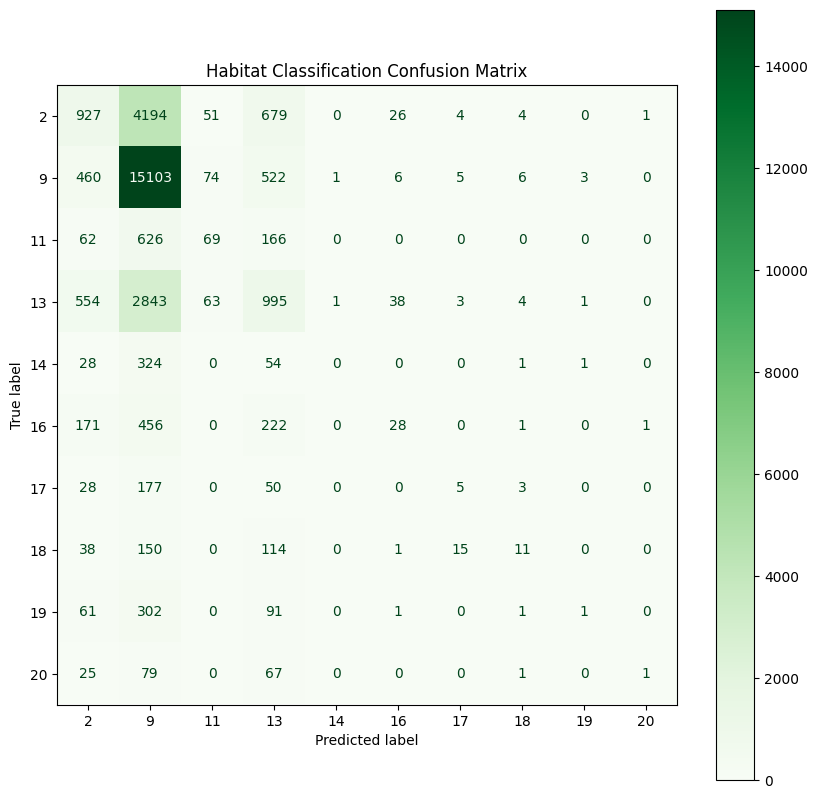


Classification Report:
              precision    recall  f1-score   support

           2       0.39      0.16      0.23      5886
           9       0.62      0.93      0.75     16180
          11       0.27      0.07      0.12       923
          13       0.34      0.22      0.27      4502
          14       0.00      0.00      0.00       408
          16       0.28      0.03      0.06       879
          17       0.16      0.02      0.03       263
          18       0.34      0.03      0.06       329
          19       0.17      0.00      0.00       457
          20       0.33      0.01      0.01       173

    accuracy                           0.57     30000
   macro avg       0.29      0.15      0.15     30000
weighted avg       0.49      0.57      0.49     30000



In [14]:
print("Generating evaluation metrics...")
y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', ax=ax)
plt.title('Habitat Classification Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Class 9 is essentially "taking over" the model. It has the most training data (16,180 pixels) and high recall (0.93), meaning the model is playing it safe by guessing Class 9 most of the time. Meanwhile, rare classes like 14, 19, and 20 are being almost completely ignored.


In [15]:
# Find the size of your smallest class (or set a target like 500 pixels)
target_samples = 1000

X_balanced = []
y_balanced = []

for class_id in np.unique(y_all[y_all > 0]):
    indices = np.where(y_all == class_id)[0]

    # If the class has fewer than our target, take all of them
    # Otherwise, take a random sample of target_samples
    n_samples = min(len(indices), target_samples)
    chosen_indices = np.random.choice(indices, n_samples, replace=False)

    X_balanced.append(X_all[chosen_indices])
    y_balanced.append(y_all[chosen_indices])

X_labeled = np.vstack(X_balanced)
y_labeled = np.concatenate(y_balanced)

print(f"New balanced dataset size: {len(y_labeled)} pixels")

New balanced dataset size: 10785 pixels


In [16]:
# class_weight='balanced' tells the model to penalize mistakes
# on small classes more heavily.
rf = RandomForestClassifier(
    n_estimators=200,    # Increased from 100
    max_depth=None,      # Allow trees to grow deeper to find differences
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
print("Training balanced model...")
rf.fit(X_train, y_train)

Training balanced model...


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

Generating evaluation metrics...


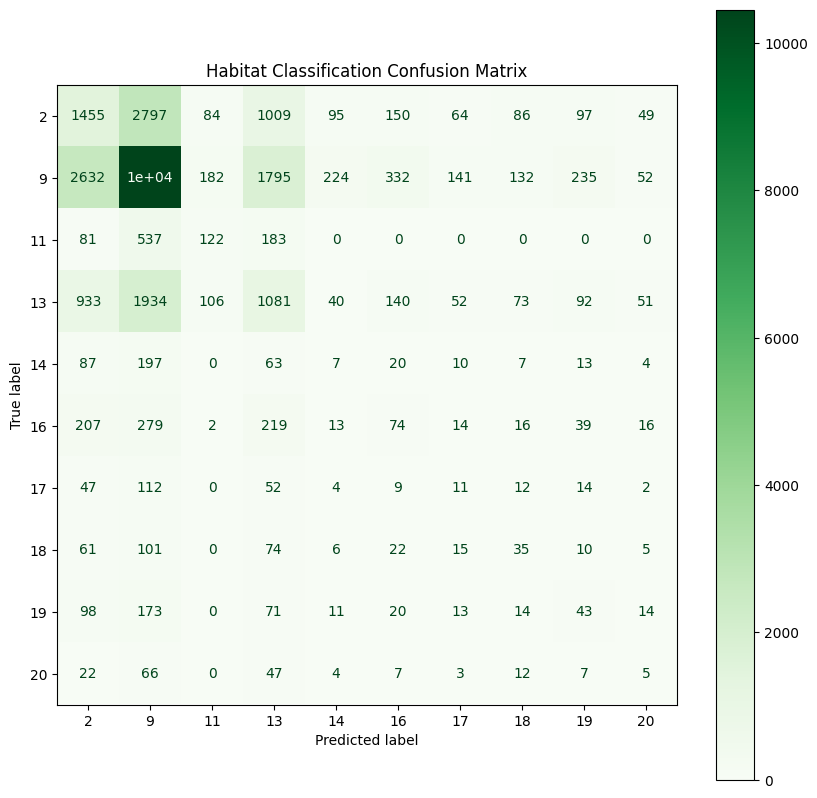


Classification Report:
              precision    recall  f1-score   support

           2       0.26      0.25      0.25      5886
           9       0.63      0.65      0.64     16180
          11       0.25      0.13      0.17       923
          13       0.24      0.24      0.24      4502
          14       0.02      0.02      0.02       408
          16       0.10      0.08      0.09       879
          17       0.03      0.04      0.04       263
          18       0.09      0.11      0.10       329
          19       0.08      0.09      0.09       457
          20       0.03      0.03      0.03       173

    accuracy                           0.44     30000
   macro avg       0.17      0.16      0.17     30000
weighted avg       0.44      0.44      0.44     30000



In [17]:
print("Generating evaluation metrics...")
y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', ax=ax)
plt.title('Habitat Classification Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy dropped from 57% to 44%, your Macro Average for recall improved ( no longer have 0.00 for the minority classes). This means the model is finally trying to identify those rare habitats instead of just ignoring them.

+texture

In [2]:
import rasterio
from rasterio.enums import Resampling
from rasterio import features
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import uniform_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
print("Opening files...")
rgb_file = rasterio.open("/content/pollardstown_ortho.tif")
ndvi_file = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")
habitat_vec = gpd.read_file("/content/Pollardstown_clappied.shp")

# Define target dimensions (using NDVI as master)
target_h, target_w = ndvi_file.height, ndvi_file.width
target_transform = ndvi_file.transform

Opening files...


In [5]:
import gc
from scipy.ndimage import uniform_filter

# 2. ALIGN DATA & CALCULATE TEXTURE (Overflow Protected)
print("Resampling RGB...")
rgb_data = rgb_file.read(
    out_shape=(rgb_file.count, target_h, target_w),
    resampling=Resampling.bilinear
)

print("Reading and Cleaning NDVI...")
ndvi_data = ndvi_file.read(1).astype('float32')

# CRITICAL FIX: Clip NDVI to valid range (-1 to 1)
# This removes the massive NoData values that cause overflow
ndvi_data = np.clip(ndvi_data, -1.0, 1.0)
ndvi_data = np.nan_to_num(ndvi_data, nan=0.0)

print("Calculating Texture (Step 1/2)...")
c1 = uniform_filter(ndvi_data, size=5)
# Squaring values between -1 and 1 will NEVER overflow
c2 = uniform_filter(np.square(ndvi_data), size=5)

print("Calculating Texture (Step 2/2)...")
texture_data = np.sqrt(np.abs(c2 - np.square(c1)))

# CLEAN UP intermediate arrays
del c1
del c2
gc.collect()

print("Stacking bands...")
img_stack = np.vstack((rgb_data,
                       ndvi_data[np.newaxis, :, :],
                       texture_data[np.newaxis, :, :]))

del rgb_data
del texture_data
gc.collect()

n_bands = img_stack.shape[0]
print(f"Stack complete. Bands: {n_bands}. No more overflows!")

Resampling RGB...
Reading and Cleaning NDVI...
Calculating Texture (Step 1/2)...
Calculating Texture (Step 2/2)...
Stacking bands...
Stack complete. Bands: 5. No more overflows!


In [7]:
print("Rasterizing shapefile to match aligned grid...")

# 1. Ensure the vector CRS matches the raster CRS
habitat_vec = habitat_vec.to_crs(ndvi_file.crs)

# 2. Create a list of (geometry, class_id) tuples
# Ensure 'class_id' is the correct column name in your shapefile
shapes = ((geom, value) for geom, value in zip(habitat_vec.geometry, habitat_vec['Id']))

# 3. Burn the polygons into a numpy array
labeled_pixels = features.rasterize(
    shapes,
    out_shape=(target_h, target_w),
    transform=target_transform,
    fill=0,            # Pixels outside polygons get 0
    all_touched=False  # Only pixels whose center is inside the polygon are labeled
)

print(f"Rasterization complete. Found classes: {np.unique(labeled_pixels)}")

Rasterizing shapefile to match aligned grid...
Rasterization complete. Found classes: [ 0  2  9 10 11 12 13 14 15 16 17 18 19 20]


In [8]:
# 1. Reshape the stack for Scikit-Learn (Pixels x Features)
# img_stack has 5 bands: Red, Green, Blue, NDVI, Texture
X_all = img_stack.reshape(n_bands, -1).T
y_all = labeled_pixels.ravel()

# 2. Define the target number of pixels per class
# 3000-5000 is usually the "Sweet Spot" for Random Forest habitat mapping
target_samples_per_class = 3000

X_balanced = []
y_balanced = []

# Get the list of actual habitat IDs (ignoring 0/background)
unique_classes = np.unique(y_all[y_all > 0])

for class_id in unique_classes:
    # Find all pixels belonging to this specific habitat
    indices = np.where(y_all == class_id)[0]

    # Check how many we actually have
    n_available = len(indices)

    if n_available > 0:
        # Take either the target amount or all available pixels if the class is rare
        n_to_draw = min(n_available, target_samples_per_class)

        # Randomly select the indices
        chosen_indices = np.random.choice(indices, n_to_draw, replace=False)

        X_balanced.append(X_all[chosen_indices])
        y_balanced.append(y_all[chosen_indices])
        print(f"Class {class_id}: Collected {n_to_draw} samples.")

# 3. Combine into final training arrays
X_labeled = np.vstack(X_balanced)
y_labeled = np.concatenate(y_balanced)

# 4. Final Train/Test Split (using 'stratify' to keep classes balanced in the test set)
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled
)

print(f"Total training pixels: {X_train.shape[0]}")
print(f"Total testing pixels: {X_test.shape[0]}")

Class 2: Collected 3000 samples.
Class 9: Collected 3000 samples.
Class 10: Collected 75 samples.
Class 11: Collected 3000 samples.
Class 12: Collected 5 samples.
Class 13: Collected 3000 samples.
Class 14: Collected 3000 samples.
Class 15: Collected 705 samples.
Class 16: Collected 3000 samples.
Class 17: Collected 3000 samples.
Class 18: Collected 3000 samples.
Class 19: Collected 3000 samples.
Class 20: Collected 3000 samples.
Total training pixels: 21549
Total testing pixels: 9236


In [9]:
print(f"Training Random Forest on {len(y_train)} pixels...")
# We keep class_weight='balanced' to give the tiny classes (like Class 12) more 'weight'
rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

Training Random Forest on 21549 pixels...


RandomForestClassifier(class_weight='balanced', max_depth=25, n_estimators=250,
                       n_jobs=-1, random_state=42)

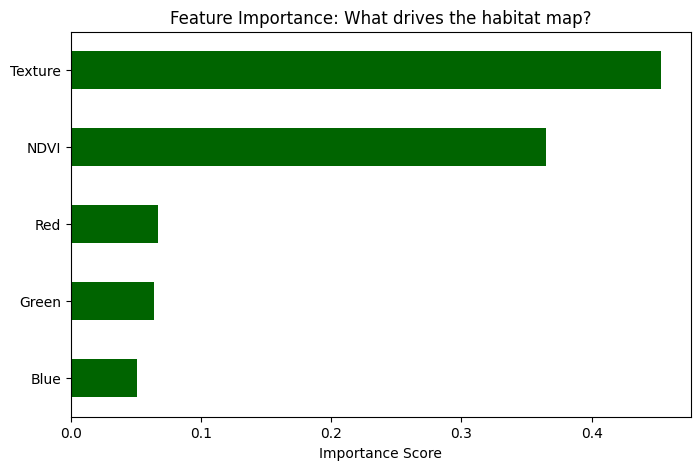

In [10]:
# This shows if 'Texture' was actually useful!
features_list = ['Red', 'Green', 'Blue', 'NDVI', 'Texture']
importances = pd.Series(rf.feature_importances_, index=features_list).sort_values()

plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='darkgreen')
plt.title("Feature Importance: What drives the habitat map?")
plt.xlabel("Importance Score")
plt.show()

In [11]:
y_pred = rf.predict(X_test)
print("\nFinal Classification Report (Balanced Data):")
print(classification_report(y_test, y_pred))


Final Classification Report (Balanced Data):
              precision    recall  f1-score   support

           2       0.16      0.10      0.13       900
           9       0.28      0.34      0.31       900
          10       0.65      0.65      0.65        23
          11       0.65      0.95      0.77       900
          12       0.01      1.00      0.02         1
          13       0.15      0.08      0.11       900
          14       0.18      0.23      0.20       900
          15       0.96      0.93      0.95       212
          16       0.30      0.25      0.27       900
          17       0.21      0.19      0.20       900
          18       0.27      0.25      0.26       900
          19       0.16      0.12      0.14       900
          20       0.24      0.32      0.28       900

    accuracy                           0.30      9236
   macro avg       0.33      0.42      0.33      9236
weighted avg       0.28      0.30      0.28      9236



every single class is being identified  
Class 11 (f1 0.77) and Class 15 (f1 0.95) are being mapped almost perfectly.  
